# Contextual data

Once you've identified areas of interest where multiple datasets intersect, you can pull additional data to provide further context. For example:

1. landcover 
2. global elevation data 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
os.environ["GDAL_PAM_ENABLED"] = "NO"

In [3]:
import coincident
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.stats import median_abs_deviation

%matplotlib inline

## Identify a primary dataset

Start by loading a full resolution polygon of a 3DEP LiDAR workunit which has a known start_datetime and end_datatime:

In [4]:
workunit = "CO_WestCentral_2019"
df_wesm = coincident.search.wesm.read_wesm_csv()
gf_lidar = coincident.search.wesm.load_by_fid(
    df_wesm[df_wesm.workunit == workunit].index
)

gf_lidar

,workunit,workunit_id,project,project_id,start_datetime,end_datetime,ql,spec,p_method,dem_gsd_meters,...,seamless_category,seamless_reason,lpc_link,sourcedem_link,metadata_link,geometry,collection,datetime,dayofyear,duration
0,CO_WestCentral_2019,175984,CO_WestCentral_2019_A19,175987,2019-08-21,2019-09-19,QL 2,USGS Lidar Base Specification 1.3,linear-mode lidar,1.0,...,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,"MULTIPOLYGON (((-106.13571 38.4146, -106.1702 ...",3DEP,2019-09-04 12:00:00,247,29


## Load raster datasets with Xarray

In [5]:
search_aoi = gf_lidar.simplify(0.01)

In [6]:
gf_wc = coincident.search.search(
    dataset="worldcover",
    intersects=search_aoi,
    # worldcover is just 2020 an 2021, so pick one
    datetime=["2020"],
)  # Asset of interest = 'map'

In [7]:
gf_cop30 = coincident.search.search(
    dataset="cop30",
    intersects=search_aoi,
)  # Asset of interest = 'data'

In [8]:
ds = coincident.io.xarray.to_dataset(
    gf_cop30,
    aoi=search_aoi,
    # chunks=dict(x=2048, y=2048), # manual chunks
    resolution=0.00081,  # ~90m
    mask=True,
).compute()

In [9]:
ds

<xarray.Dataset> Size: 14MB
Dimensions:      (latitude: 1538, longitude: 2288, time: 1)
Coordinates:
  * latitude     (latitude) float64 12kB 39.39 39.39 39.39 ... 38.15 38.14 38.14
  * longitude    (longitude) float64 18kB -108.0 -108.0 -108.0 ... -106.1 -106.1
  * time         (time) datetime64[ns] 8B 2021-04-22
    spatial_ref  int64 8B 0
Data variables:
    data         (time, latitude, longitude) float32 14MB nan nan ... nan nan

In [10]:
ds = ds.rename(data="elevation")

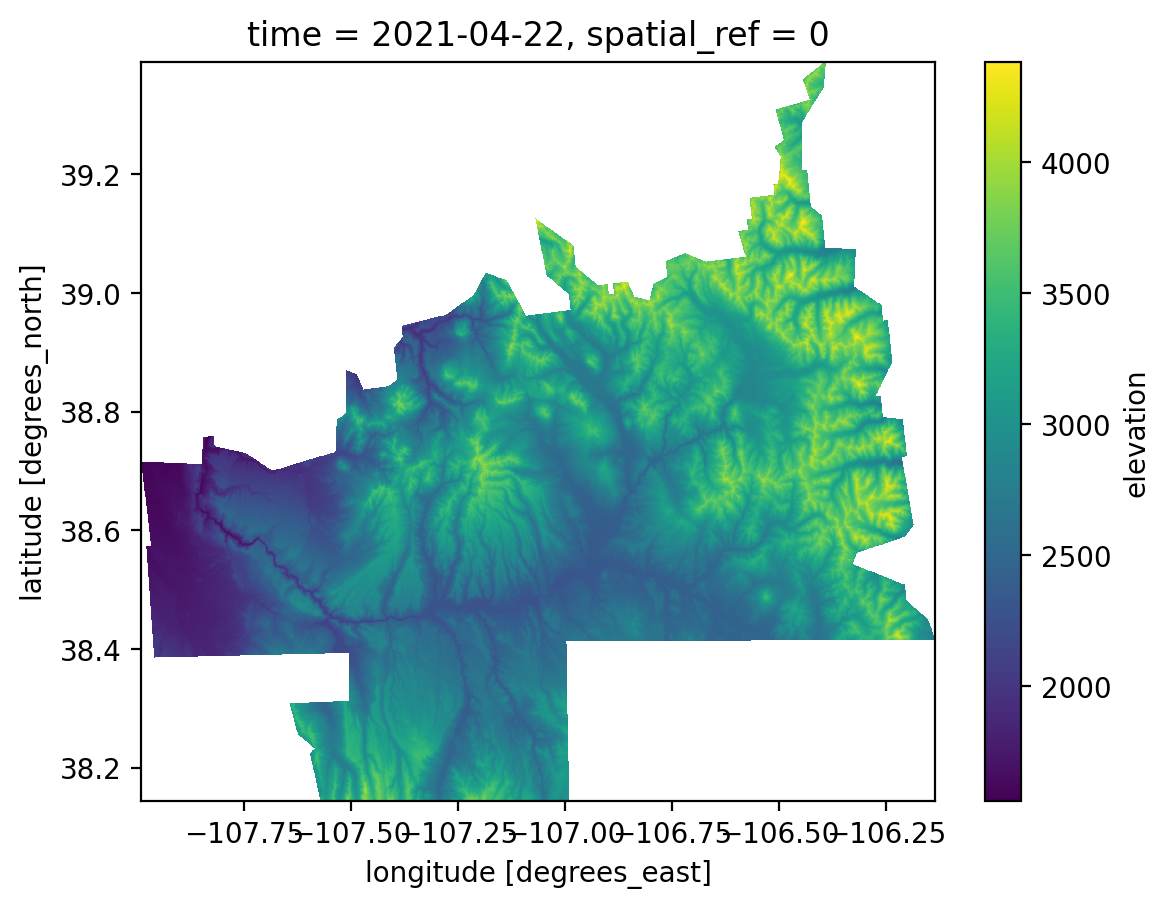

In [11]:
ds.elevation.isel(time=0).plot.imshow();

In [12]:
# Same with LandCover
ds = coincident.io.xarray.to_dataset(
    gf_wc,
    bands=["map"],
    aoi=search_aoi,
    mask=True,
    # resolution=0.00027, #~30m
    resolution=0.00081,  # ~90m
)
ds

<xarray.Dataset> Size: 4MB
Dimensions:      (latitude: 1538, longitude: 2288, time: 1)
Coordinates:
  * latitude     (latitude) float64 12kB 39.39 39.39 39.39 ... 38.15 38.14 38.14
  * longitude    (longitude) float64 18kB -108.0 -108.0 -108.0 ... -106.1 -106.1
  * time         (time) datetime64[ns] 8B 2020-01-01
    spatial_ref  int64 8B 0
Data variables:
    map          (time, latitude, longitude) uint8 4MB dask.array<chunksize=(1, 1538, 2288), meta=np.ndarray>

In [13]:
ds = ds.rename(map="landcover")

In [14]:
ds = ds.compute()

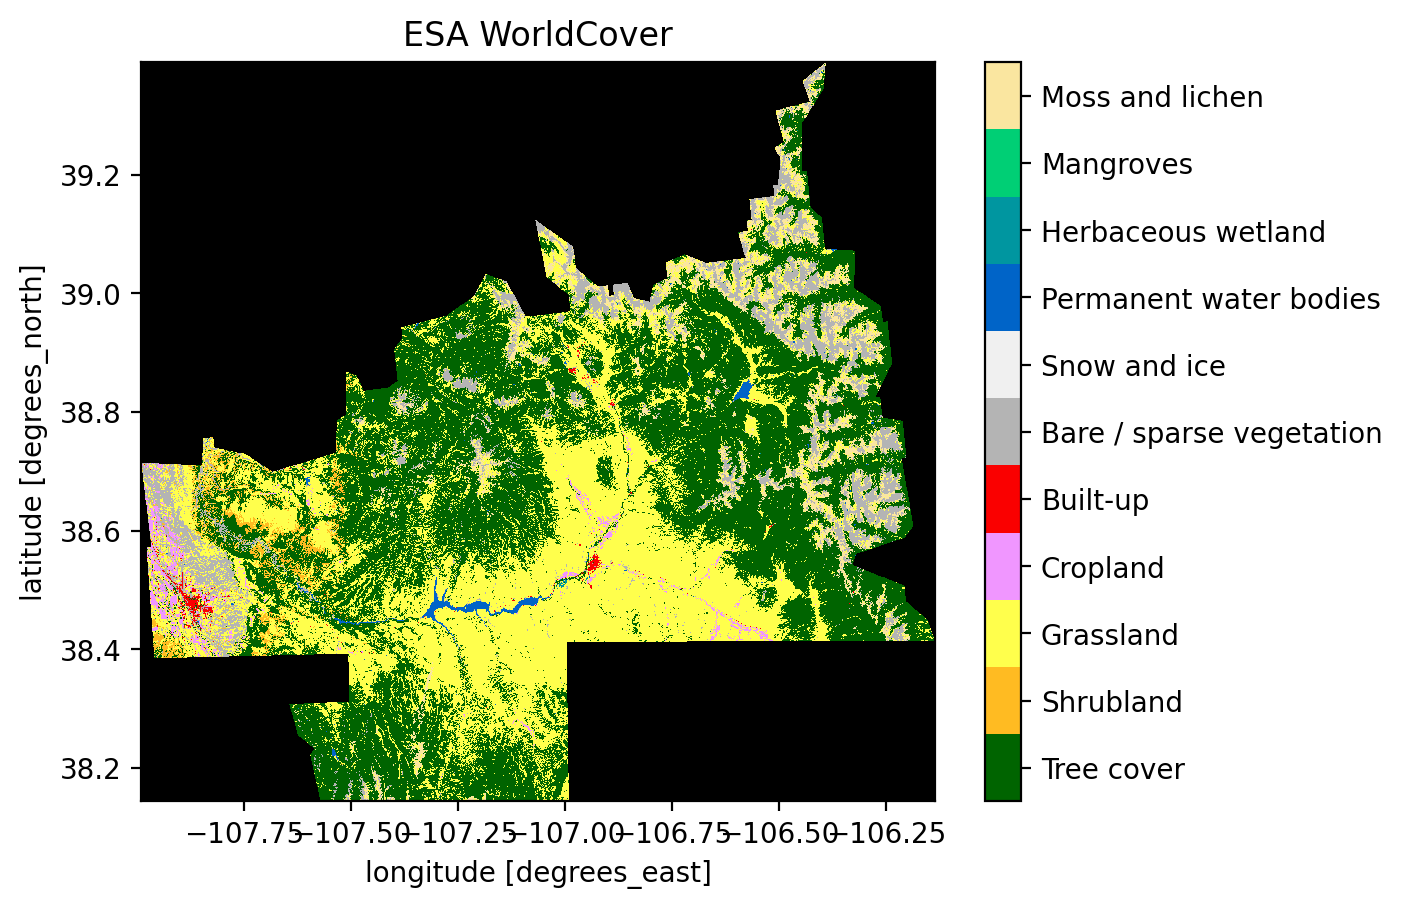

In [15]:
ax = coincident.io.xarray.plot_esa_worldcover(ds)
ax.set_title("ESA WorldCover");

## Sample rasters at points with Sliderule

Xarray is great for analysis and visualization of raster datasets, but if you are only interested in sampling at points (e.g. GEDI or ICESat-2 points) then you can use Sliderule to efficiently sample a number of raster datasets including ESA WorldCover, Copernicus DEM, and USGS 1m 3DEP DEMs

In [16]:
# Get all icesat-2 tracks, and analyze based on landcover
is2 = coincident.datasets.nasa.ICESat2()
is2.collections = ["ATL06_006"]
print(is2)

ICESat2(alias='icesat-2', has_stac_api=True, collections=['ATL06_006'], search='https://cmr.earthdata.nasa.gov/stac/NSIDC_ECS', start='2018-10-13', end=None, type='altimeter', provider='nasa', stac_kwargs={'limit': 1000})


In [17]:
secondary_datasets = [
    ("gedi", 40),  # +/- 40 days from lidar
    (is2, 60),  # +/- 60 days from lidar
]

gf_gedi, gf_is2 = coincident.search.cascading_search(
    gf_lidar,
    secondary_datasets,
    min_overlap_area=30,  # km^2
)

In [18]:
len(gf_gedi)

20

In [19]:
len(gf_is2)

2

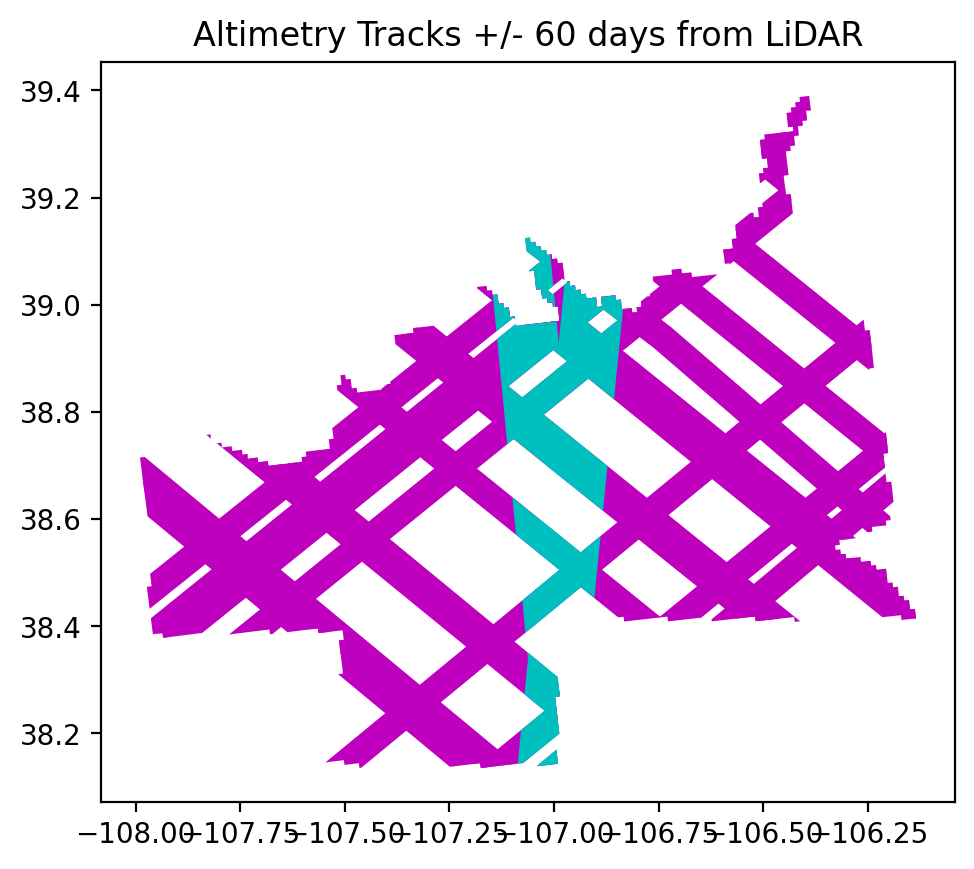

In [20]:
# Plot all the tracks
fig, ax = plt.subplots()
gf_gedi.plot(ax=ax, color="m", label="GEDI")  # column='id'
gf_is2.plot(ax=ax, color="c", label="ICESat-2")  # column='id'
plt.title("Altimetry Tracks +/- 60 days from LiDAR");

In [21]:
# Retrieve points only where overlap occurs (cyan area)
data_is2 = coincident.io.sliderule.subset_atl06(gf_is2)
data_gedi = coincident.io.sliderule.subset_gedi02a(
    gf_gedi,
    aoi=gf_is2,
)

In [22]:
utm_crs = gf_is2.estimate_utm_crs()
subset_is2 = data_is2.to_crs(utm_crs)
subset_gedi = data_gedi.to_crs(utm_crs)

In [23]:
# find nearest IS2 point to each GEDI
close_points = subset_gedi.sjoin_nearest(
    subset_is2,
    how="left",
    lsuffix="gedi",
    rsuffix="is2",
    max_distance=100,  # at most 100m apart
    distance_col="distances",
)
# common columns are distinguised by _gedi or _is2
# Only GEDI geometry is kept
close_points = close_points[close_points["distances"].notna()]
len(close_points)

814

In [24]:
# Sample 3DEP at these nearest points... slow :(
data_3dep = coincident.io.sliderule.sample_3dep(
    close_points,
    project_name=gf_lidar["project"].iloc[0],
)

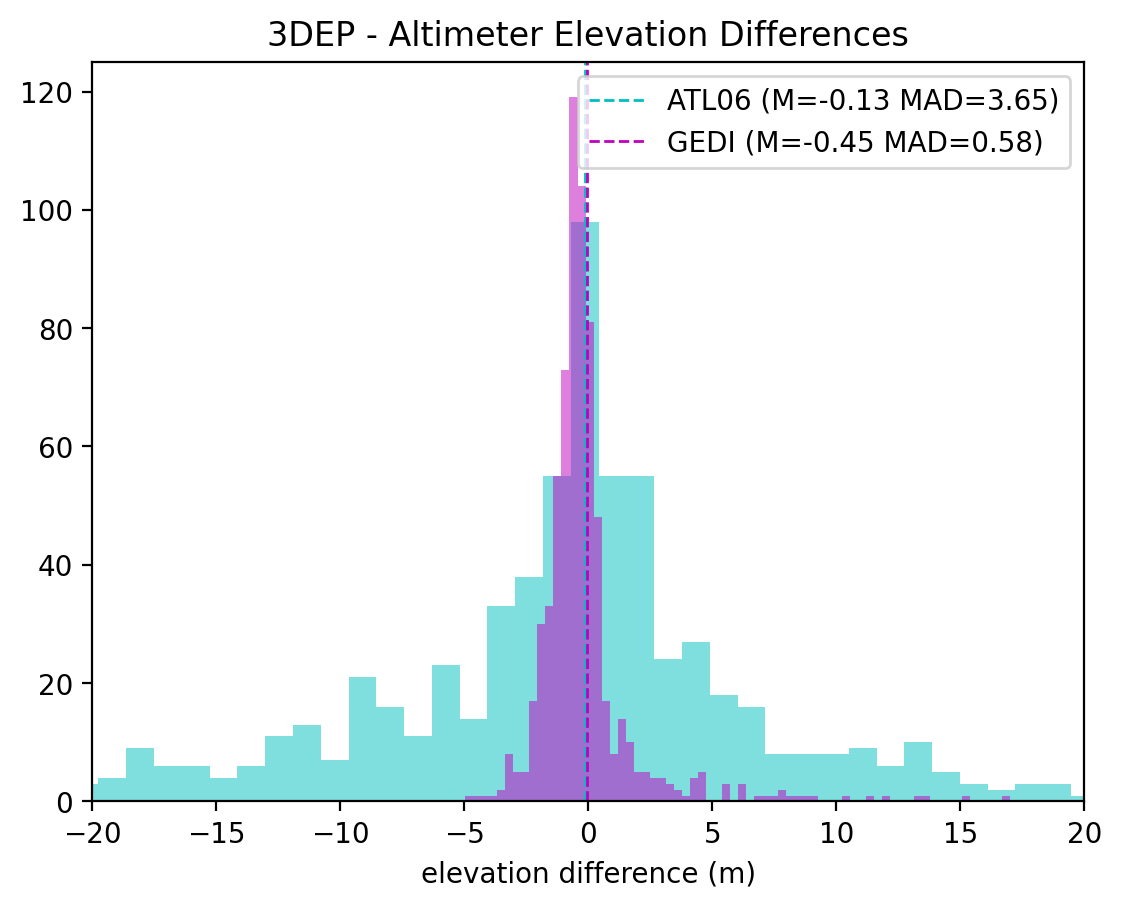

In [25]:
# Plot histograms... do a panel based on landcover class?

diff_atl06_3dep = data_3dep.value.values - close_points.h_li.values
diff_gedi_3dep = data_3dep.value.values - close_points.elevation_lm.values

# NOTE: should probably use nmad/nmedian
# label = f'ATL06 (μ={np.nanmean(diff_atl06_3dep):.2f} σ={np.nanstd(diff_atl06_3dep):.2f})'
mad = median_abs_deviation(diff_atl06_3dep, nan_policy="omit")
median = np.nanmedian(diff_atl06_3dep)
label = f"ATL06 (M={median:.2f} MAD={mad:.2f})"
plt.axvline(
    np.nanmedian(diff_atl06_3dep),
    color="c",
    linestyle="dashed",
    linewidth=1,
    label=label,
)
plt.hist(diff_atl06_3dep, bins=100, color="c", alpha=0.5)

# label = f'GEDI2A (μ={np.nanmean(diff_gedi_3dep):.2f} σ={np.nanstd(diff_gedi_3dep):.2f})'
mad = median_abs_deviation(diff_gedi_3dep, nan_policy="omit")
median = np.nanmedian(diff_gedi_3dep)
label = f"GEDI (M={median:.2f} MAD={mad:.2f})"
plt.axvline(
    np.nanmean(diff_gedi_3dep), color="m", linestyle="dashed", linewidth=1, label=label
)
plt.hist(diff_gedi_3dep, bins=100, color="m", alpha=0.5)

plt.xlim(-20, 20)
plt.xlabel("elevation difference (m)")
plt.title("3DEP - Altimeter Elevation Differences")
plt.legend();

## Analyze landcover

In [87]:
# keepcols = ['elevation_lm', 'h_li','time_is2','time_gedi','distances']
# pd.concat([results,close_points.reset_index()[keepcols]])
close_points["elevation_3dep"] = data_3dep.value.values

In [ ]:
# NOTE: better ways to code this... should use xvec
def get_landcover(coord):
    return ds.sel(
        longitude=coord.x, latitude=coord.y, method="nearest"
    ).landcover.values[0]


# get_landcover(coords.iloc[0])
coords = close_points.to_crs(4326).get_coordinates()
landcover = coords.apply(get_landcover, axis=1)

In [85]:
close_points["landcover"] = landcover
# NOTE: add 0: NaN
mapping = {
    key: value["description"]
    for (
        key,
        value,
    ) in coincident.datasets.planetary_computer.WorldCover.classmap.items()
}
mapping[0] = "Outside AOI"
close_points = close_points.replace(dict(landcover=mapping))
close_points["landcover"].value_counts()

landcover
Grassland                   434
Tree cover                  227
Outside AOI                 124
Moss and lichen              15
Bare / sparse vegetation      6
Built-up                      4
Cropland                      4
Name: count, dtype: int64

In [89]:
gf_tree = close_points[close_points.landcover.str.contains("Tree")]
gf_grass = close_points[close_points.landcover.str.contains("Grass")]

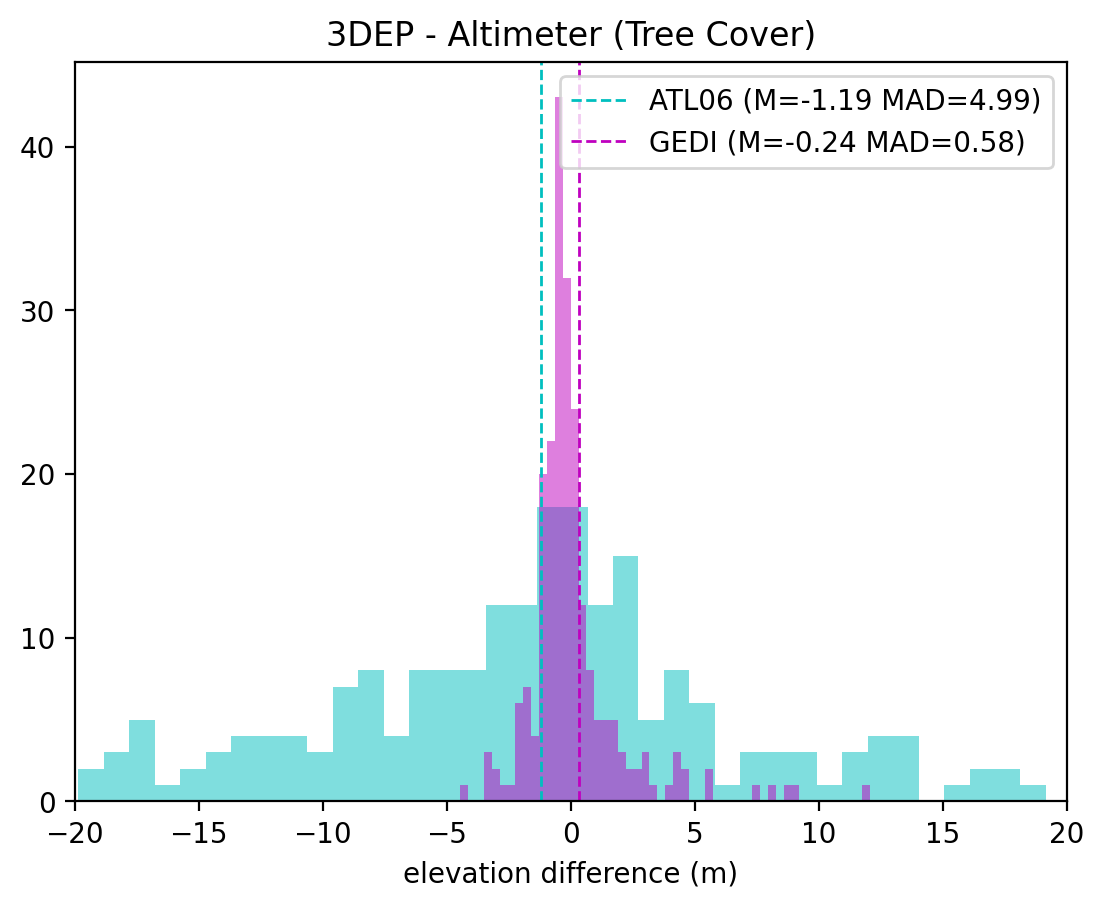

In [95]:
def plot_diffs(gf, title="Tree Cover"):
    diff_atl06_3dep = gf.elevation_3dep - gf.h_li.values
    diff_gedi_3dep = gf.elevation_3dep - gf.elevation_lm.values

    # NOTE: should probably use nmad/nmedian
    # label = f'ATL06 (μ={np.nanmean(diff_atl06_3dep):.2f} σ={np.nanstd(diff_atl06_3dep):.2f})'
    mad = median_abs_deviation(diff_atl06_3dep, nan_policy="omit")
    median = np.nanmedian(diff_atl06_3dep)
    label = f"ATL06 (M={median:.2f} MAD={mad:.2f})"
    plt.axvline(
        np.nanmedian(diff_atl06_3dep),
        color="c",
        linestyle="dashed",
        linewidth=1,
        label=label,
    )
    plt.hist(diff_atl06_3dep, bins=100, color="c", alpha=0.5)

    # label = f'GEDI2A (μ={np.nanmean(diff_gedi_3dep):.2f} σ={np.nanstd(diff_gedi_3dep):.2f})'
    mad = median_abs_deviation(diff_gedi_3dep, nan_policy="omit")
    median = np.nanmedian(diff_gedi_3dep)
    label = f"GEDI (M={median:.2f} MAD={mad:.2f})"
    plt.axvline(
        np.nanmean(diff_gedi_3dep),
        color="m",
        linestyle="dashed",
        linewidth=1,
        label=label,
    )
    plt.hist(diff_gedi_3dep, bins=100, color="m", alpha=0.5)

    plt.xlim(-20, 20)
    plt.xlabel("elevation difference (m)")
    plt.title(f"3DEP - Altimeter ({title})")
    plt.legend()


plot_diffs(gf_tree)

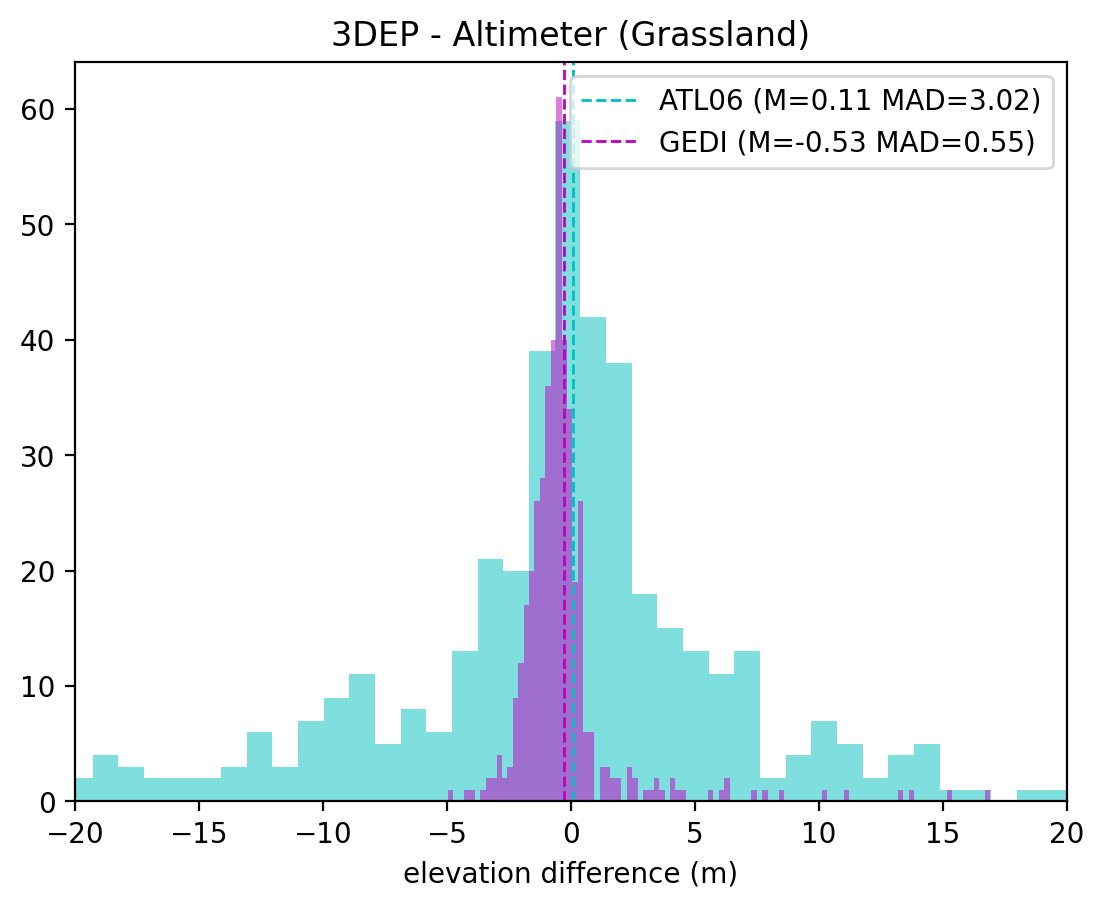

In [96]:
plot_diffs(gf_grass, title="Grassland")